In [258]:
from quantization import *

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from scipy.spatial import Voronoi
from scipy.stats import multivariate_normal
from scipy.stats import norm

### I. $L^2$ optimal quantization for a gaussian random variable 

#### I.1 $d=1$

In [40]:
data_1d = np.loadtxt("dim_1/200_1_nopti.txt")
weights_1d = data_1d[:-1, 0]
points_1d = data_1d[:-1, 1]
weights_1d /= np.sum(weights_1d)

In [42]:
cmap = plt.cm.viridis
color_norm = Normalize(vmin=weights_1d.min(), vmax=weights_1d.max())
colors = cmap(color_norm(weights_1d))

x_grid = np.linspace(-5, 5, 500)
pdf = norm.pdf(x_grid)

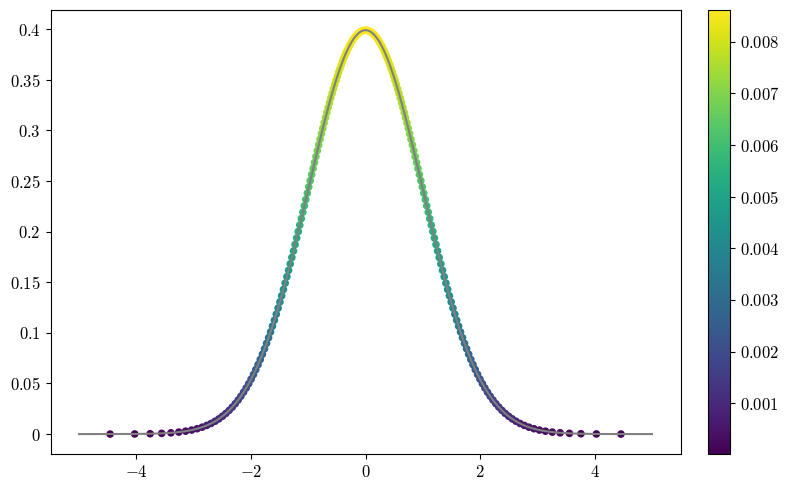

In [64]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(x_grid, pdf, color="gray")

ax.scatter(points_1d, norm.pdf(points_1d), color=colors, s=20)

sm = ScalarMappable(norm=color_norm, cmap=cmap)
sm.set_array(weights_1d)
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)

ax.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax.tick_params(axis='both', labelsize=12)
cbar.ax.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

#### I.2 $d=2$

In [87]:
def plot_voronoi_2d(ax, vor, **plot_kwargs):
    center = vor.points.mean(axis=0)
    radius = 10

    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            ax.plot(vor.vertices[simplex,0], vor.vertices[simplex,1], **plot_kwargs)
        else:
            i = simplex[simplex >= 0][0]
            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]
            t = t / np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[i] + direction * radius

            ax.plot([vor.vertices[i,0], far_point[0]], [vor.vertices[i,1], far_point[1]], **plot_kwargs)

In [89]:
data = np.loadtxt("mult_dimensional_grids/200_2_nopti.txt")
weights = data[:-1, 0]
x1 = data[:-1, 1]
x2 = data[:-1, 2]
points = np.column_stack((x1, x2))

vor = Voronoi(points)

X, Y = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
pos = np.dstack((X, Y))
rv = multivariate_normal(mean=[0, 0], cov=np.eye(2))
Z = rv.pdf(pos)

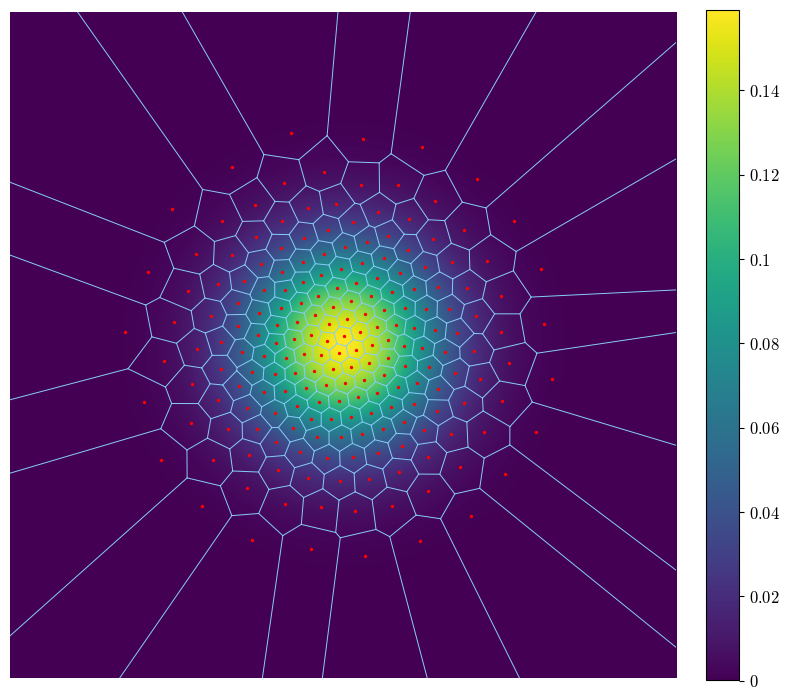

In [103]:
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(Z, extent=[-5, 5, -5, 5], origin="lower", cmap="viridis", alpha=1.0)
plot_voronoi_2d(ax, vor, color="lightskyblue", linewidth=0.7)

ax.scatter(x1, x2, color="red", s=2, alpha=1)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_aspect("equal")
ax.axis("off")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

### II. $L^2$ optimal quantization for the Brownian motion

#### II.1 $d=1$

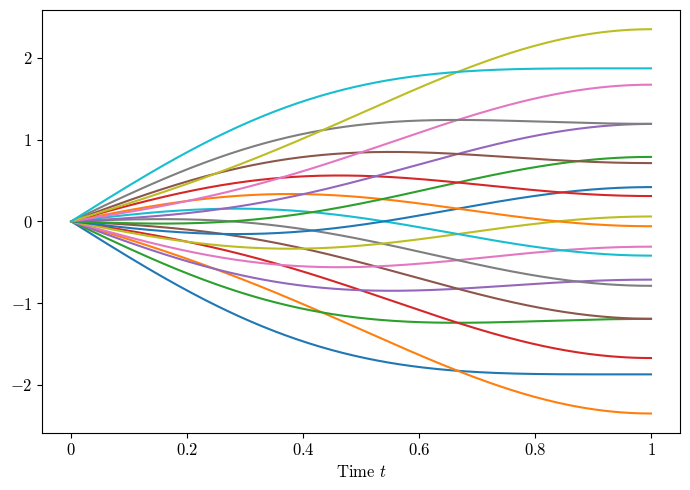

In [122]:
N_target = 20
T = 1 
n = 252
t_grid = np.linspace(0, T, n+1) 
t_vals = np.linspace(0, T, n+1) 
decomposition = get_optimal_decomposition("RECORD_QF.txt", N_target) # 20 = 10 * 2 
traj, poids = generate_brownian_quantized_trajectories(T, t_vals, decomposition)

fig, ax = plt.subplots(figsize=(7,5))
for k in range(N_target) : 
    ax.plot(t_grid, traj[k,:])

ax.set_xlabel(r"$\text{Time }t$", fontsize=12)
ax.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
ax.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

#### II.2 $d=2$

In [246]:
def plot_trajectories_2D(trajectoires, t_vals) : 
    N = trajectoires.shape[0]

    fig = plt.figure(figsize=(6, 6))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('white')

    for i in range(trajectoires.shape[0]):
        traj = trajectoires[i]  
        ax.plot(t_vals, traj[:, 0], traj[:, 1])
        
    ax.set_xlabel(r"$\text{Time }t$", fontsize=12, labelpad=5)
    ax.set_ylabel(r"$\widehat{W}^{\,(1)}$", fontsize=12, labelpad=5)
    ax.set_zlabel(r"$\widehat{W}^{\,(2)}$", fontsize=12, labelpad=5)

    ax.xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    ax.yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax.zaxis.set_major_formatter(lambda z, _: f"${z:g}$")
    ax.tick_params(axis="both", labelsize=12)

    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor("lightgray")

    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [254]:
d = 2
N_target = 40
T = 1 
n = 252
t_grid = np.linspace(0, T, n+1) 
decomposition = get_optimal_decomposition("RECORD_QF.txt", N_target)

traj, weights = generate_brownian_d_quantized_trajectories(T, t_vals, decomposition, d)

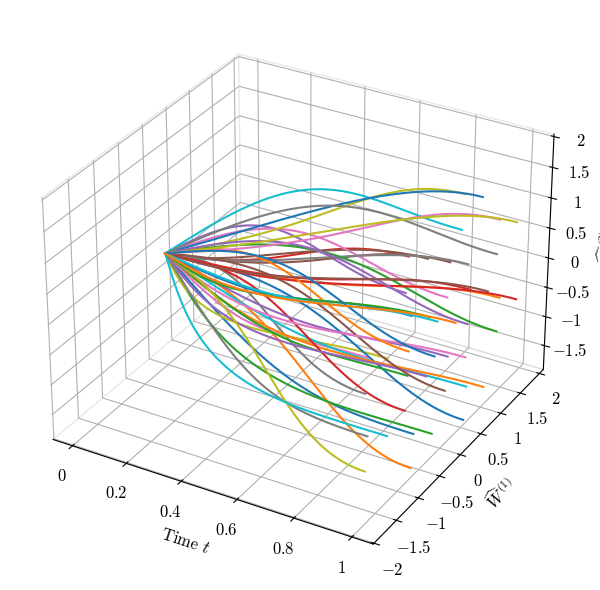

In [256]:
plot_trajectories_2D(traj, t_grid) 

### $d=1$. 

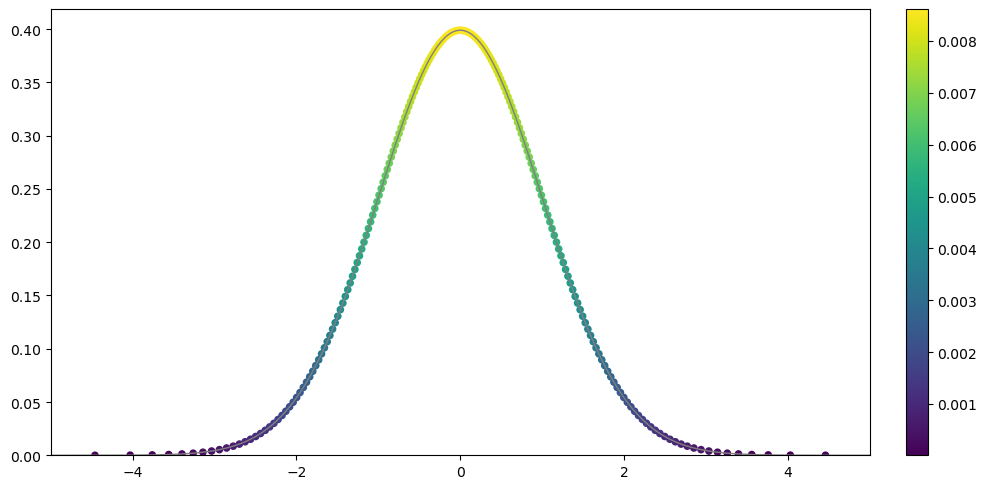

In [79]:
data_1d = np.loadtxt("dim_1/200_1_nopti.txt")
weights_1d = data_1d[:-1, 0]
points_1d = data_1d[:-1, 1]
weights_1d /= np.sum(weights_1d)

cmap = plt.cm.viridis
color_norm = Normalize(vmin=weights_1d.min(), vmax=weights_1d.max())
colors = cmap(color_norm(weights_1d))

x_grid = np.linspace(-5, 5, 500)
pdf = norm.pdf(x_grid)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x_grid, pdf, color='gray', lw=1, label='Densité gaussienne')

ax.scatter(
    points_1d,  
    norm.pdf(points_1d),
    c=colors, 
    s=20
)

ax.set_xlim([-5, 5])
ax.set_ylim(bottom=0)

sm = ScalarMappable(norm=color_norm, cmap=cmap)
sm.set_array(weights_1d)
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.savefig("Exemple_gaussian_1d_quantization.pdf")
plt.show()

### $d = 2$. 

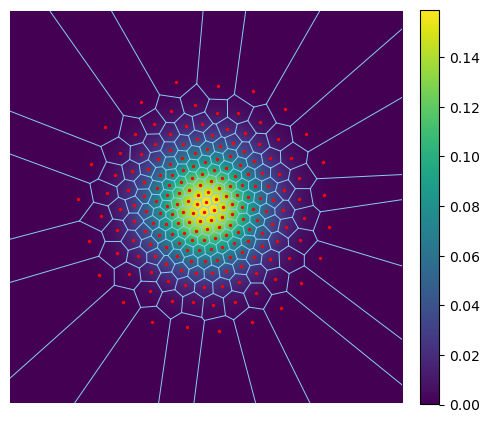

In [33]:
data = np.loadtxt("mult_dimensional_grids/200_2_nopti.txt")
weights = data[:-1, 0]
x1 = data[:-1, 1]
x2 = data[:-1, 2]
points = np.column_stack((x1, x2))

vor = Voronoi(points)

X, Y = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
pos = np.dstack((X, Y))
rv = multivariate_normal(mean=[0, 0], cov=np.eye(2))
Z = rv.pdf(pos)

def plot_voronoi_2d(ax, vor, **plot_kwargs):
    center = vor.points.mean(axis=0)
    radius = 10

    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            ax.plot(vor.vertices[simplex,0], vor.vertices[simplex,1], **plot_kwargs)
        else:
            i = simplex[simplex >= 0][0]
            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]
            t = t / np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[i] + direction * radius

            ax.plot([vor.vertices[i,0], far_point[0]], [vor.vertices[i,1], far_point[1]], **plot_kwargs)

fig, ax = plt.subplots(figsize=(5, 5))

im = ax.imshow(
    Z,
    extent=[-5, 5, -5, 5],
    origin='lower',
    cmap='viridis',
    alpha=1.0
)

plot_voronoi_2d(ax, vor, color='lightskyblue', linewidth=0.7)

ax.scatter(x1, x2, color='red', s=2, alpha=1)

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_aspect('equal')
ax.axis('off')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.savefig("quantization_gaussian_2D.pdf")
plt.show()

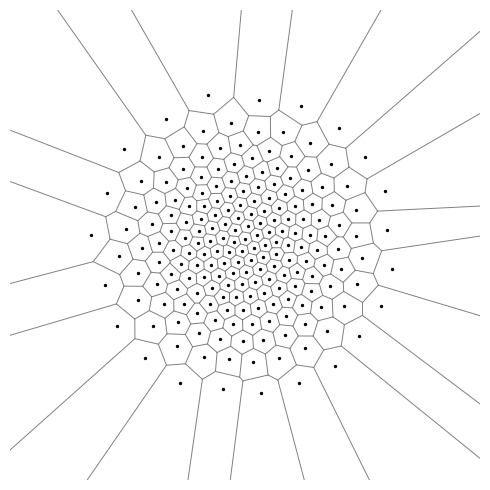

In [57]:
data = np.loadtxt("mult_dimensional_grids/200_2_nopti.txt")
weights = data[:-1, 0]
x1 = data[:-1, 1]
x2 = data[:-1, 2]
points = np.column_stack((x1, x2))

vor = Voronoi(points)

X, Y = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
pos = np.dstack((X, Y))
rv = multivariate_normal(mean=[0, 0], cov=np.eye(2))
Z = rv.pdf(pos)

def plot_voronoi_2d(ax, vor, **plot_kwargs):
    center = vor.points.mean(axis=0)
    radius = 10

    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            ax.plot(vor.vertices[simplex,0], vor.vertices[simplex,1], **plot_kwargs)
        else:
            i = simplex[simplex >= 0][0]
            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]
            t = t / np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[i] + direction * radius

            ax.plot([vor.vertices[i,0], far_point[0]], [vor.vertices[i,1], far_point[1]], **plot_kwargs)

fig, ax = plt.subplots(figsize=(5, 5))

"""im = ax.imshow(
    Z,
    extent=[-5, 5, -5, 5],
    origin='lower',
    cmap='viridis',
    alpha=1.0
)"""

plot_voronoi_2d(ax, vor, color='gray', linewidth=0.7)

ax.scatter(x1, x2, color='black', s=2, alpha=1)

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_aspect('equal')
ax.axis('off')

#cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.savefig("paper_quantization_gaussian_2D.pdf")
plt.show()